# **ESRGAN with TF-GAN**

### **Overview**
This notebook demonstrates the E2E process of data loading, preprocessing, training and evaluation of the [ESRGAN](https://arxiv.org/abs/1809.00219) model using Tensorflow and Tf-GAN. To understand the basics of Tf-GAN and explore more features of the library, please visit [Tf-GAN tutorial](https://github.com/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb) notebook first. 

### **Steps to run this notebook**


* Click on the following icon to open this notebook in Google Colaboratory. <br>
> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb)
(temp link)

*  Navigate to `Runtime > Change runtime type` tab 
* Select GPU from hardware accelerator and save
* Click Connect in the upper right corner and select Connect to hosted runtime.








In [1]:
# Check that imports for the rest of the file work.
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import os
import numpy as np
from absl import logging
from functools import partial
import tensorflow as tf
import PIL
from tensorflow.python.data.experimental import AUTOTUNE

     |████████████████████████████████| 368kB 2.9MB/s 



### **Learning Objectives**
Through this Colab notebook you will learn how to :
* Implement the ESRGAN model and train it
* Make use of various Tf-GAN functions to visualize and evaluate the results. 

### **Training ESRGAN**
The ESRGAN model proposed in the paper [ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks (Wang Xintao et al.)](https://arxiv.org/abs/1809.00219) performs the task of image super-resolution which is the process of reconstructing high resolution (HR) image from a given low resolution (LR) image. Please go through the paper to have a deeper understanding of the model. 

These are the steps followed in this notebook :
>1.    **[Define Parameters](#scrollTo=Gj0cUphO2b8I&uniqifier=2)**
2.    **[Load DIV2K Training Data](#scrollTo=aFlwIkdgY_Gq)**
2.    **[Implement ESRGAN Generator](#scrollTo=vN12V5iSZBdv)**
3.    **[Implement ESRGAN Discriminator](#scrollTo=2LVuaWw9ZC6x)**
4.    **[Define Loss Functions](#scrollTo=yv37ead1Lm-U&uniqifier=2)**
4.    **[Phase 1 Training](#scrollTo=I2RGB6fGZFgx)**
5.    **[Phase 2 Training](#scrollTo=VZy7ed72NyQh)**
6.    **[Loading DIV2K Validation Data](#scrollTo=pXqL3xv3ZLAO)**
6.    **[Evaluating the Model](#scrollTo=pXqL3xv3ZLAO)**


In [ ]:
#temporary
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/GSoC-2021-TF-GAN/Code/Scripts /content/
from Scripts import model, utils

## Define Parameters


In [15]:
Params = {
    'batch_size' : 32,
    'hr_size' : 96,
    'scale' : 4,
    'trunk_size' : 3,
    'init_lr' : 0.00005,    
    'ph1_steps' : 3000,
    'ph2_steps' : 30000,
    'decay_ph1' : 0.2,
    'decay_ph2' : 0.5,
    'model_dir' : '/content/saved',
    'lambda' : 0.005,
    'eta' : 0.01,
    'val_steps' : 100
}

## Load Training Dataset
We have used the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset which is usually used for benchmarking super resolution models. DIV2K dataset provides various kinds of image from which we are downloading only the HR images and corresponding LR images downsampled using bicubic downsampling. All the HR images are also scaled to 96 x 96 and LR images to 28 x 28.    

In [4]:
def download_hr(mode, target_dir):
    filename = 'DIV2K_{}_HR.zip'.format(mode)
    os.makedirs(target_dir, exist_ok=True)
    source_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/' + filename 
    tf.keras.utils.get_file(filename, source_url, cache_subdir=target_dir, extract = True)

def download_lr(mode, target_dir):
    filename = 'DIV2K_{}_LR_bicubic_X4.zip'.format(mode)
    os.makedirs(target_dir, exist_ok=True)
    source_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/' + filename
    tf.keras.utils.get_file(filename, source_url, cache_subdir=target_dir,extract = True)

In [5]:
def scale(lr_img, hr_img, hr_crop_size = Params['hr_size'], scale = Params['scale']):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_scaled = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_scaled = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_scaled, hr_img_scaled

In [6]:
def hr_data(mode, data_dir):
    target_dir = data_dir + 'HR_{}_data'.format(mode)
    download_hr(mode, target_dir)
    
    start_index = 1 if mode == 'train' else 801
    end_index = 801 if mode == 'train' else 901

    img_list = [target_dir + '/DIV2K_{}_HR/{:04}.png'.format(mode, image_id) 
                for image_id in range(start_index,end_index)]

    ds = tf.data.Dataset.from_tensor_slices(img_list)
    ds = ds.map(tf.io.read_file)
    ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)

    return ds

def lr_data(mode, data_dir):
    target_dir = data_dir + 'LR_{}_data'.format(mode)
    download_lr(mode, target_dir)
    start_index = 1 if mode == 'train' else 801
    end_index = 801 if mode == 'train' else 901
    
    img_list = [target_dir + '/DIV2K_{}_LR_bicubic/X4/{:04}x4.png'.format(mode, image_id) 
                for image_id in range(start_index,end_index)]
    
    ds = tf.data.Dataset.from_tensor_slices(img_list)
    ds = ds.map(tf.io.read_file)
    ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
    return ds

def get_div2k_data(data_dir = None, 
                   mode = 'train',  
                   augment = False, 
                   HR_size = Params['hr_size'], 
                   batch_size = Params['batch_size'],
                   Scale = 4,
                   repeat_count = None):

    ds = tf.data.Dataset.zip((lr_data(mode, data_dir), hr_data(mode, data_dir)))
    ds = ds.map(lambda lr, hr: scale(lr, hr, HR_size, Scale), num_parallel_calls=AUTOTUNE)
    
    if augment:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.repeat(repeat_count)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [7]:
train_ds = get_div2k_data(data_dir = '/content/dataset/', mode = 'train')

3530604544/3530603713 [==============================] - 29s 0us/step


### Plotting Sample Images

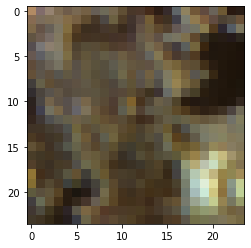

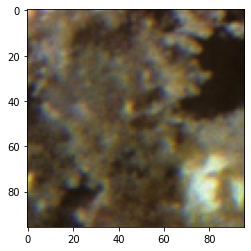

In [8]:
import matplotlib.pyplot as plt

for lr, hr in train_ds.take(1):
  arr_ = np.squeeze(lr[0]) 
  plt.imshow(arr_)
  plt.show()

  arr2 = np.squeeze(hr[0]) 
  plt.imshow(arr2)
  plt.show()

## Network Architecture
The basic network buidling unit of the  ESRGAN is the Residual-in-Residual Block (RRDB) without batch normalization. The network implemented is similar to the architecture proposed in the paper.

### Generator

In [22]:
from keras.models import Model
from keras.layers import Input, Add
from keras.layers import LeakyReLU, Conv2D 
#temporary
from Scripts.model import RRDB, upsample

def ESRGAN_G(trunk_size = Params['trunk_size'], out_channels = 3):
    lr_input = Input(shape=(None, None, 3))
    
    x = Conv2D(32, kernel_size= [3,3], strides=[1,1], padding='same', use_bias = True)(lr_input)
    x = LeakyReLU(0.2)(x)

    ref = x
    
    for i in range(trunk_size):
        x = RRDB(x)

    x = Conv2D(32, kernel_size= [3,3], strides=[1,1], padding='same', use_bias = True)(x)
    x = Add()([x, ref])

    x = upsample(x, 1)
    x = LeakyReLU(0.2)(x)

    x = upsample(x, 2)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(32, kernel_size= [3,3], strides=[1,1], padding='same', use_bias = True)(x)
    x = LeakyReLU(0.2)(x)

    hr_output = Conv2D(out_channels, kernel_size= [3,3], strides=[1,1], padding='same', use_bias = True)(x)

    model = Model(inputs=lr_input, outputs=hr_output)
    return model

### Discriminator


In [13]:
from keras.models import Model
from keras.layers import Input, Add
from keras.layers import LeakyReLU, Dense, Dropout
from Scripts.model import _conv_block_d

def ESRGAN_D(filters = 64):
    img = Input(shape = (None, None, 3))
    
    x = _conv_block_d(img, filters, bn=False)
    x = _conv_block_d(x, filters = filters, strides=2)
    x = _conv_block_d(x, filters = filters * 2)

    x = _conv_block_d(x, filters = filters * 2, strides=2)
    x = _conv_block_d(x, filters = filters * 4)
    
    x = _conv_block_d(x, filters = filters * 4, strides=2)
    x = _conv_block_d(x, filters = filters * 8)
    
    x = _conv_block_d(x, filters = filters * 8, strides=2)

    x = Dense(filters * 16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)

    model = Model(inputs = img, outputs = x)
    return model

## Loss Functions
The ESRGAN model makes use of three loss functions - Pixel loss (L1 Loss), Perceptual loss and RaGAN loss. These loss functions ensures the balance between visual quality and metrics such as PSNR and encorages the generator to produce more realistic images with natural textures.  

In [12]:
def pixel_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.reduce_mean(tf.abs(y_true - y_pred), axis = 0))


def RealitivisticAverageLoss(non_trans_disc, type_ = "G"):
    loss = None

    def D_Ra(x, y):
        return non_trans_disc(x) - tf.reduce_mean(non_trans_disc(y))

    def loss_D(y_true, y_pred):
        real_logits = D_Ra(y_true, y_pred)
        fake_logits = D_Ra(y_pred, y_true)

        real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(real_logits), logits=real_logits))
        fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(fake_logits), logits=fake_logits))
        
        return real_loss + fake_loss
    
    def loss_G(y_true, y_pred):
        real_logits = D_Ra(y_true, y_pred)
        fake_logits = D_Ra(y_pred, y_true)
        
        real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(real_logits), logits=real_logits)
        fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(fake_logits), logits=fake_logits)
        
        return real_loss + fake_loss
    
    return loss_G if type == "G" else loss_D


def PerceptualLoss(weight = None, input_shape = None, loss_type = "L1"):
    vgg_model = tf.keras.applications.vgg19.VGG19(
        input_shape = input_shape, weights = weight, include_top = False
    )

    for layer in vgg_model.layers:
        layer.trainable = False
    
    vgg_model.get_layer("block5_conv4").activation = lambda x: x
    phi = tf.keras.Model(
        inputs = [vgg_model.input],
        outputs =[vgg_model.get_layer("block5_conv4").output])
    
    def loss(y_true, y_pred):
      if loss_type.lower() == "l1":
        return tf.compat.v1.losses.absolute_difference(phi(y_true), phi(y_pred))

      if loss_type.lower() == "l2":
        return tf.reduce_mean(
            tf.reduce_mean((phi(y_true) - phi(y_pred))**2, axis=0))
    return loss

## Training
ESRGAN model is trained in two phases in which the first phase deals with training the generator network individually and is aimed at improving the PSNR values of generated images by reducing the L1 loss.  

Training of the same generator model is continued in the second phase along with the discriminator network. In the second phase, the generator reduces the L1 Loss, Relativistic average GAN (RaGAN) loss which indicates how realistic does the generated image look and the imporved Perceptual loss proposed in the paper.  


### Phase - 1

Steps Involved:

* Define the generator and its optimizer. 
* Take LR, HR image pairs from the training dataset
* Input the LR image to the generator network
* Calculate the L1 loss using the generated image and HR image
* Calculate gradient value and apply it to the optimizer
* Update the learning rate of optimizer after every decay steps for better performance

In [25]:
metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

generator = ESRGAN_G()

G_optimizer = tf.optimizers.Adam(
    learning_rate = 0.0002,
    beta_1 = 0.9,
    beta_2 = 0.99
)

In [26]:
def train_step(image_lr, image_hr):
  with tf.GradientTape() as tape:
    fake = generator(image_lr)
    loss = pixel_loss(image_hr, fake) * (1.0 / Params['batch_size'])

    psnr_metric(tf.reduce_mean(tf.image.psnr(fake, image_hr,max_val = 256.0)))
    metric(loss)
    
    gradient = tape.gradient(loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))

In [29]:
steps = 6000
step = 0

for lr, hr in train_ds.take(steps):
  lr = tf.cast(lr, tf.float32)
  hr = tf.cast(hr, tf.float32)
  
  train_step(lr, hr)

  if step % 1000 == 0:
    print("step {}".format(step) + "     Generator Loss = {}".format(metric.result()) + "     PNSR = {}".format(psnr_metric.result()))
  step += 1
  
  if not step % 500:
    G_optimizer.learning_rate.assign(G_optimizer.learning_rate * 0.5)  

step 0     Generator Loss = 3.542365550994873     PNSR = 12.702705383300781
step 1000     Generator Loss = 0.8590044975280762     PNSR = 24.585378646850586
step 2000     Generator Loss = 0.6937389373779297     PNSR = 26.47364616394043
step 3000     Generator Loss = 0.6312741041183472     PNSR = 27.27436065673828
step 4000     Generator Loss = 0.5985851287841797     PNSR = 27.727842330932617
step 5000     Generator Loss = 0.578506588935852     PNSR = 27.996444702148438


In [ ]:
os.makedirs(model_dir + '/Phase_1/generator', exist_ok = True)
generator.save(model_dir + '/Phase_1/generator')


###**Phase - 2**

* Load the generator network trained in Phase 1
* Load the discriminator
* Define RaGAN loss and Perceptual loss
* Take LR, HR image pairs from the training dataset
* Input the LR image to the generator network
* Using the generated image and HR image calcualte L1 loss, Perceptual loss and RaGAN loss for both generator and discriminator.
* Update the optimizer for both networks using the obtained gradient values
* Update the learning rate of optimizers after every decay steps for better performance
* Tf-GAN's image grid function is used to display the generated images during training. 

In [ ]:
optimizer = tf.optimizers.Adam(
    learning_rate = 0.0002,
    beta_1 = 0.9,
    beta_2 = 0.99
)

generator = tf.keras.models.load_model(model_dir + '/Phase_1/generator/')
discriminator = ESRGAN_D()

G_optimizer = optimizer
G_optimizer.learning_rate.assign(0.00005)
D_optimizer = optimizer

In [13]:
ra_gen = RealitivisticAverageLoss(discriminator, type_ = "G")
ra_disc = RealitivisticAverageLoss(discriminator, type_ = "D")

In [14]:
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

In [15]:
perceptual_loss = PerceptualLoss(
        weight = "imagenet",
        input_shape = [Params['hr_size'], Params['hr_size'], 3],
        loss_type = 'L1'
    )

80142336/80134624 [==============================] - 0s 0us/step


In [16]:
def visualize_results(image_lr, generated, image_hr):
    size = 128
    resized_lr = tf.image.resize(image_lr, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_gen = tf.image.resize(generated, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_hr = tf.image.resize(image_hr, [size, size], method=tf.image.ResizeMethod.BILINEAR)

    stack = tf.stack([resized_lr[0], resized_gen[0], resized_hr[0]])

    image_grid = tfgan.eval.python_image_grid(stack, grid_shape=(1, 3))
    result = PIL.Image.fromarray(image_grid.astype(np.uint8))
    return result

In [17]:
def train_step(image_lr, image_hr):
   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     pred = generator(image_lr)
     
     fake = utils.preprocess_input(pred)
     image_lr = utils.preprocess_input(image_lr)
     image_hr = utils.preprocess_input(image_hr)

     percep_loss = tf.reduce_mean(perceptual_loss(image_hr, fake)) 
     l1_loss = pixel_loss(image_hr, fake) 
     loss_RaG = ra_gen(image_hr, fake) 
    
     disc_loss = ra_disc(image_hr, fake)

     gen_loss = percep_loss + Params['lambda'] * loss_RaG + Params['eta'] * l1_loss

     gen_loss = gen_loss * (1.0 / Params['batch_size'])
     disc_loss = disc_loss * (1.0 / Params['batch_size'])

     disc_metric(disc_loss) 
     gen_metric(gen_loss)

     psnr_metric(tf.reduce_mean(tf.image.psnr(fake, image_hr, max_val = 256.0)))
     
     disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
     D_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

     gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables) 
     G_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
     return pred

step 0   Generator Loss = 0.3174082040786743   Disc Loss = 2.7095711538729396e-15   PSNR : 27.89488983154297


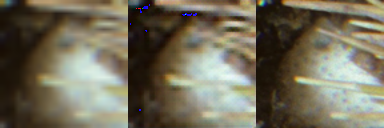

step 1000   Generator Loss = 0.3398175835609436   Disc Loss = 0.0003813172224909067   PSNR : 28.04543685913086


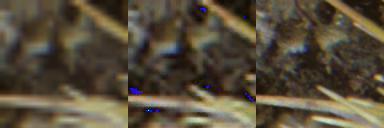

step 2000   Generator Loss = 0.3392179310321808   Disc Loss = 0.00019075478485319763   PSNR : 28.055362701416016


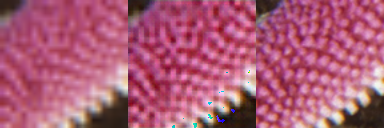

step 3000   Generator Loss = 0.3382464349269867   Disc Loss = 0.00012912815145682544   PSNR : 28.075191497802734


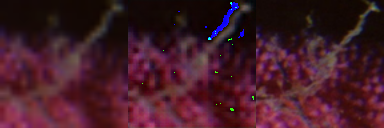

step 4000   Generator Loss = 0.3369266390800476   Disc Loss = 9.685437544248998e-05   PSNR : 28.10036277770996


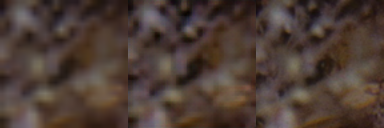

step 5000   Generator Loss = 0.3361090123653412   Disc Loss = 7.748736970825121e-05   PSNR : 28.103116989135742


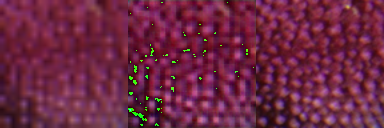

step 6000   Generator Loss = 0.33514440059661865   Disc Loss = 6.463799218181521e-05   PSNR : 28.118194580078125


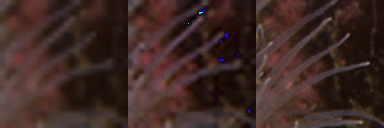

step 7000   Generator Loss = 0.33391037583351135   Disc Loss = 5.7507648307364434e-05   PSNR : 28.133092880249023


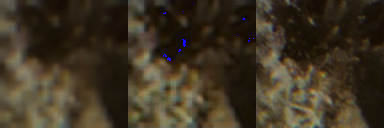

step 8000   Generator Loss = 0.33273395895957947   Disc Loss = 5.034933201386593e-05   PSNR : 28.15110206604004


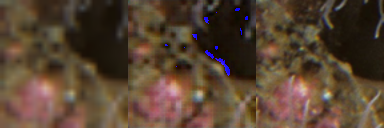

step 9000   Generator Loss = 0.3312845230102539   Disc Loss = 4.475564492167905e-05   PSNR : 28.18406867980957


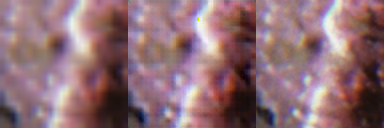

step 10000   Generator Loss = 0.33025699853897095   Disc Loss = 4.028100738651119e-05   PSNR : 28.21031379699707


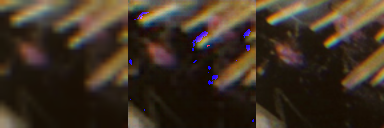

step 11000   Generator Loss = 0.3293120563030243   Disc Loss = 3.662362360046245e-05   PSNR : 28.23495864868164


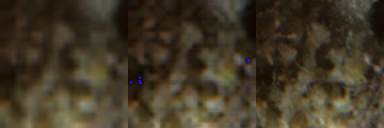

step 12000   Generator Loss = 0.3286488950252533   Disc Loss = 3.357201421749778e-05   PSNR : 28.25402069091797


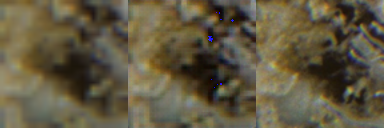

step 13000   Generator Loss = 0.32793140411376953   Disc Loss = 3.1002957257442176e-05   PSNR : 28.26805305480957


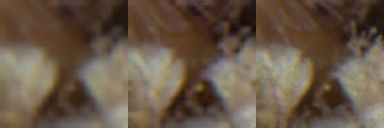

step 14000   Generator Loss = 0.32734575867652893   Disc Loss = 2.8788752388209105e-05   PSNR : 28.284120559692383


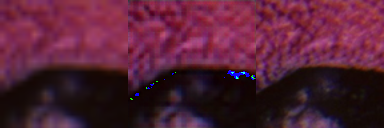

step 15000   Generator Loss = 0.3267734944820404   Disc Loss = 2.687040250748396e-05   PSNR : 28.297456741333008


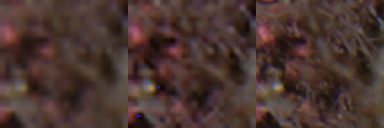

step 16000   Generator Loss = 0.32627564668655396   Disc Loss = 2.519117515475955e-05   PSNR : 28.309967041015625


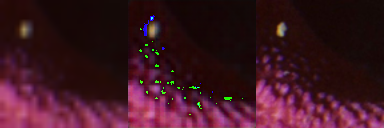

step 17000   Generator Loss = 0.3258615732192993   Disc Loss = 2.37094300246099e-05   PSNR : 28.319255828857422


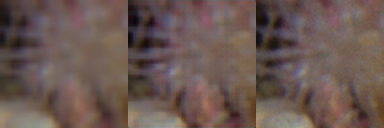

step 18000   Generator Loss = 0.3254184126853943   Disc Loss = 2.2392398022930138e-05   PSNR : 28.330644607543945


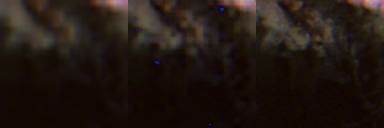

step 19000   Generator Loss = 0.3251602053642273   Disc Loss = 2.1213912987150252e-05   PSNR : 28.337392807006836


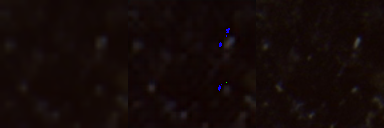

step 20000   Generator Loss = 0.3248845934867859   Disc Loss = 2.0153271179879084e-05   PSNR : 28.342430114746094


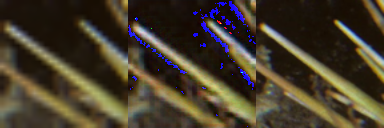

step 21000   Generator Loss = 0.3246224522590637   Disc Loss = 1.9193641492165625e-05   PSNR : 28.348251342773438


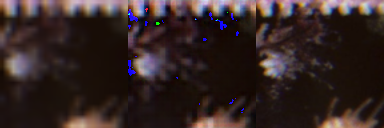

step 22000   Generator Loss = 0.324434369802475   Disc Loss = 1.832194539019838e-05   PSNR : 28.353721618652344


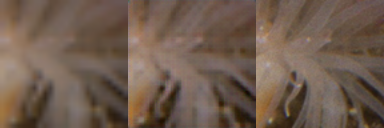

step 23000   Generator Loss = 0.32416749000549316   Disc Loss = 1.7525380826555192e-05   PSNR : 28.360549926757812


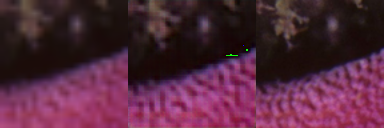

step 24000   Generator Loss = 0.3240363597869873   Disc Loss = 1.679522029007785e-05   PSNR : 28.364233016967773


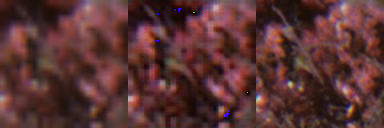

step 25000   Generator Loss = 0.32396695017814636   Disc Loss = 1.61236384883523e-05   PSNR : 28.36545753479004


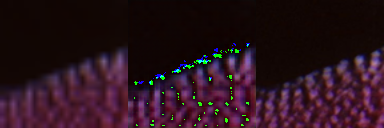

step 26000   Generator Loss = 0.32379594445228577   Disc Loss = 1.5503543181694113e-05   PSNR : 28.36898422241211


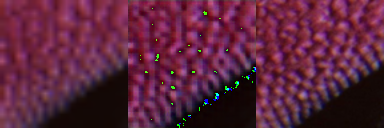

step 27000   Generator Loss = 0.32359713315963745   Disc Loss = 1.4929360077076126e-05   PSNR : 28.373451232910156


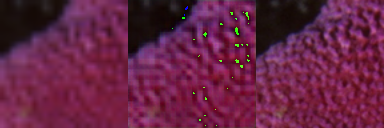

step 28000   Generator Loss = 0.32343047857284546   Disc Loss = 1.439795596525073e-05   PSNR : 28.376989364624023


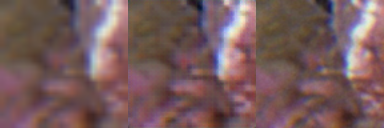

step 29000   Generator Loss = 0.323288232088089   Disc Loss = 1.3901512829761487e-05   PSNR : 28.379512786865234


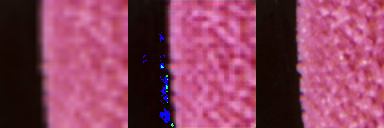

In [18]:
steps = 30000
step = 0
previous_loss = 0

decay_step = [8000, 10000, 20000, 30000]
decay_factor = 0.2

for lr, hr in train_ds.take(steps):
  lr = tf.cast(lr, tf.float32)
  hr = tf.cast(hr, tf.float32)
  
  fake = train_step(lr, hr)

  if step % 1000 == 0:
    print("step {}".format(step) + "   Generator Loss = {}   ".format(gen_metric.result()) + 
        "Disc Loss = {}".format(disc_metric.result()) + "   PSNR : {}".format(psnr_metric.result()))
    

    display(visualize_results(lr,fake, hr))

  step += 1

  if step >= decay_step[0]:
    decay_step.pop(0)
    G_optimizer.learning_rate.assign(
              G_optimizer.learning_rate * decay_factor)
    
    D_optimizer.learning_rate.assign(
        D_optimizer.learning_rate * decay_factor)

## Evaluation

FID and Inception Scores are two common metrices used to evaluate the performance of a GAN model and PSNR value is used to quantify the similarity between two images and is used for benchmarking super resolution models. 


In [12]:
val_ds = get_div2k_data(data_dir = '/content/dataset', mode = 'valid')

448995328/448993893 [==============================] - 18s 0us/step


In [13]:
def get_fid_score(real_image, gen_image):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

  resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
  
  num_inception_images = 8
  num_batches = Params['batch_size'] // num_inception_images
  
  fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images, num_batches=num_batches)
  return fid

def get_inception_score(images, num_inception_images = 8):
  size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
  resized_images = tf.image.resize(images, [size, size], method=tf.image.ResizeMethod.BILINEAR)

  num_batches = Params['batch_size'] // num_inception_images
  inc_score = tfgan.eval.inception_score(resized_images, num_batches=num_batches)

  return inc_score

In [20]:
fid_metric = tf.keras.metrics.Mean()
inc_metric = tf.keras.metrics.Mean()
psnr_metric = tf.keras.metrics.Mean()

In [ ]:
count = 0
for lr, hr in val_ds.take(Params['val_steps']):  
  gen = generator(lr)
  fid = get_fid_score(hr, gen)
  real_is = get_inception_score(hr)
  gen_is = get_inception_score(gen)

  fid_metric(fid)
  inc_metric(gen_is)
  psnr_metric(tf.reduce_mean(tf.image.psnr(gen, hr, max_val = 256.0)))